In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy.spatial.distance import cdist

In [2]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /Users/benjaminlaubach/Documents/GitHub/chimes_CGD-myLLFork/dissimilarity_clustering


In [3]:
# Get the current working directory
cwd = os.getcwd()

# Define file paths with cwd appended
file_path_2b = os.path.join(cwd, "dft_pds/2b_all_pd")
file_path_3b = os.path.join(cwd, "dft_pds/3b_all_pd")
file_path_4b = os.path.join(cwd, "dft_pds/4b_all_pd")
file_path_labels = os.path.join(cwd, "dft_pds/labels_pd")
file_path_natoms = os.path.join(cwd, "test_notebooks/energies_per_atom.txt")

# Open pickle files with the updated file paths
with open(file_path_2b, 'rb') as pickle_file:
    pd_2b = pickle.load(pickle_file)

with open(file_path_3b, 'rb') as pickle_file:
    pd_3b = pickle.load(pickle_file)

with open(file_path_4b, 'rb') as pickle_file:
    pd_4b = pickle.load(pickle_file)

with open(file_path_labels, 'rb') as pickle_file:
    labels = pickle.load(pickle_file)

natom_list = []

# Open the text file for reading
with open(file_path_natoms, 'r') as file:

    # Read the contents of the file
    lines = file.readlines()[1:]

    # Iterate through each line
    for line in lines:

        # Split the line into words
        words = line.split()
        natoms = line.split("|")[1].strip()

        # Extract the last word, assuming it's a number
        last_number = float(words[-1])
        if words[0][-1] == 'z':
            print(words[0])
            continue
        natom_list.append(natoms)

natom_list = np.array(natom_list[:-10])

# Combine the arrays along the second axis (axis=1)
all_array = np.concatenate((pd_2b, pd_3b, pd_4b), axis=2)
all_array = all_array.reshape(-1, all_array.shape[2])
print(np.shape(all_array))
df_fingerprints = pd.DataFrame(all_array)

# Define the column labels for each set of columns
column_labels_2b = [f'2B_{i}' for i in range(60)]
column_labels_3b = [f'3B_{i}' for i in range(60)]
column_labels_4b = [f'4B_{i}' for i in range(60)]

# Assign the column labels to the DataFrame
column_labels = column_labels_2b + column_labels_3b + column_labels_4b
df_fingerprints.columns = column_labels

# Add a new column "labels" to the DataFrame and assign the new vector to it
df_fingerprints['labels'] = labels

# Calculate the row-wise mean using `mean(axis=1)`
row_avg = df_fingerprints.mean(axis=1)

# Append the calculated row-wise mean as a new column named "Pavg"
df_fingerprints['Pavg'] = row_avg

# Calculate the row-wise standard deviation using `std(axis=1)`
row_std = df_fingerprints.std(axis=1)

# Append the calculated row-wise standard deviation as a new column named "Pstd"
df_fingerprints['Pstd'] = row_std

# Append Natoms to Dataframe
df_fingerprints['Natoms'] = natom_list

df_fingerprints.head()


training_data_#0000.xyz
training_data_#0050.xyz
training_data_#0055.xyz
training_data_#0060.xyz
training_data_#0075.xyz
training_data_#0080.xyz
training_data_#0110.xyz
(300, 180)


,2B_0,2B_1,2B_2,2B_3,2B_4,2B_5,2B_6,2B_7,2B_8,2B_9,...,4B_54,4B_55,4B_56,4B_57,4B_58,4B_59,labels,Pavg,Pstd,Natoms
0,0.151940,0.079974,0.039987,0.134957,0.000000,0.039987,0.000000,0.059981,0.000000,0.064979,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.016335,0.025764,216
1,0.151838,0.089548,0.030670,0.107863,0.026939,0.039628,0.000530,0.059527,0.008709,0.053400,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.016335,0.024411,216
2,0.152059,0.091794,0.027968,0.104630,0.029103,0.039305,0.001128,0.058054,0.005966,0.057973,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.016335,0.024316,216
3,0.113888,0.093885,0.074372,0.063481,0.048075,0.037675,0.033869,0.031662,0.025958,0.021373,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.016348,0.020050,216
4,0.118745,0.094125,0.073008,0.061039,0.048168,0.036493,0.032401,0.030655,0.026413,0.021867,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.016344,0.020228,216


In [4]:
# Initialize the minimum occurrence count required
def compute_pij(phi1, phi2):

    # Compute statistics for training set
    phi1_fingerprint = phi1.iloc[:-4]
    phi1_fingerprint.to_numpy()
    phi1_2b = phi1_fingerprint[:60]
    phi1_3b = phi1_fingerprint[60:120]
    phi1_4b = phi1_fingerprint[120:]

    # Compute statistics for phi2
    phi2_fingerprint = phi2.iloc[:-4]
    phi2_fingerprint.to_numpy()
    phi2_2b = phi2_fingerprint[:60]
    phi2_3b = phi2_fingerprint[60:120]
    phi2_4b = phi2_fingerprint[120:]

    distance_2b = np.linalg.norm((phi1_2b - phi2_2b), ord=1)
    distance_3b = np.linalg.norm((phi1_3b - phi2_3b), ord=1)
    distance_4b = np.linalg.norm((phi1_4b - phi2_4b), ord=1)

    distance = distance_2b + distance_3b + distance_4b

    return distance

n = int(len(df_fingerprints))
pij_matrix = np.zeros((n,n))

# Iterate over each pair of rows
for i in range(n):
    for j in range(n):
        # Compute the scalar using compute_pij function
        pij = compute_pij(df_fingerprints.iloc[i], df_fingerprints.iloc[j])
        # Assign the scalar to the corresponding index in zeros_array
        pij_matrix[i, j] = pij

# np.fill_diagonal(pij_matrix, -np.inf)
pij_matrix = np.nan_to_num(pij_matrix, nan=0)
print(pij_matrix)

[[0.         0.4225557  0.44224512 ... 1.76637985 1.80654152 1.78103057]
 [0.4225557  0.         0.10336075 ... 1.55630838 1.59632321 1.57271221]
 [0.44224512 0.10336075 0.         ... 1.53187806 1.57002412 1.54862714]
 ...
 [1.76637985 1.55630838 1.53187806 ... 0.         0.11935155 0.05125147]
 [1.80654152 1.59632321 1.57002412 ... 0.11935155 0.         0.09027395]
 [1.78103057 1.57271221 1.54862714 ... 0.05125147 0.09027395 0.        ]]


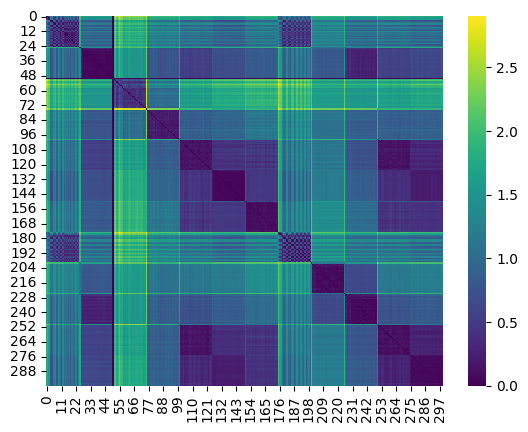

In [5]:
import seaborn as sns

# Create a heatmap with Seaborn
sns.heatmap(pij_matrix, cmap='viridis', vmin=0)

# Display the heatmap
plt.show()

55
75
100
250
175
200
225
25
52
176
57
150
177
51
56
1
54
174
2
72
162
201
181
62
189
69
164
202
192
63
182
60
157
195
220
71
185
65
186
169
68
204
173
67
12
210
198
53
163
9
74
6
203
58
172
70
159
209
61
22
161
66
207
24
59
167
197
64
223
155
73
205
154
217
5
160
213
17
215
170
190
219
152
19
212
153
214
125
178
222
193
83
151
224
165
78
14
216
156
206
81
15
221
158
79
188
211
92
171
218
95
13
298
208
194
166
76
93
168
10
80
191
97
226
183
90
283
82
229
280
196
84
199
99
112
275
91
187
96
107
20
134
237
21
88
254
87
180
130
247
184
252
94
129
179
234
98
136
16
232
85
268
292
244
77
8
128
86
118
23
227
270
18
140
7
231
89
293
11
242
281
264
4
230
146
241
3
251
289
124
147
240
269
235
149
236
115
246
148
272
238
137
243
253
299
233
109
239
138
276
248
287
249
135
119
228
131
245
145
256
104
142
284
113
132
102
126
114
127
111
27
290
108
139
33
141
273
30
288
26
143
31
103
291
28
265
37
144
48
133
260
34
294
261
46
279
29
116
297
40
122
36
285
39
262
101
49
258
45
296
121
42
295
41
267
2

Text(0.5, 1.0, 'Training Set Optimization with Pij Matrix')

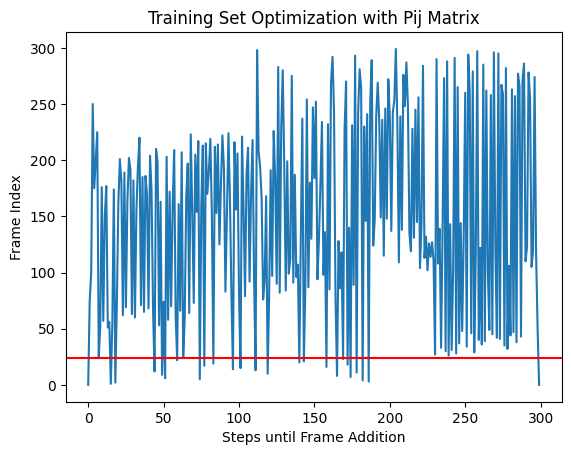

In [6]:
def calculate_min_pij(frame_pij_matrix):

    if frame_pij_matrix.ndim == 1:
        frame_pij_matrix = frame_pij_matrix.reshape(1, -1)  # Reshape into a single row
        max_index = np.argmax(first_column)
    else:

        # Sum each row
        row_sums = np.sum(frame_pij_matrix, axis=1)

        # Find the index of the row with the minimum sum
        max_index = np.argmax(row_sums)
    print(max_index)

    return max_index

def update_datasets(training_frames, available_frames, pij_matrix_copy, training_pij, max_index):

    pij_matrix_copy[max_index, :] = -np.inf
    column_n = pij_matrix_copy[:, max_index-1:max_index]
    training_pij = np.hstack((training_pij, column_n))

    row_to_append = available_frames.loc[max_index]
    training_frames = pd.concat([training_frames, row_to_append], axis=1, join="inner")

    return training_frames, available_frames, pij_matrix_copy, training_pij


starting_frame = 0
training_set = pd.DataFrame()
training_set = pd.concat([training_set, df_fingerprints.iloc[starting_frame]])
pij_matrix_copy = copy.copy(pij_matrix)

# Modify Pij matrix
pij_matrix_copy[starting_frame, :] = -np.inf
training_pij_copy = copy.copy(pij_matrix_copy[:, :1])

# Extract the first column
first_column = pij_matrix_copy[:, starting_frame]
max_index = calculate_min_pij(first_column)

frame_list = [0]
for i in range(299):
    training_set, df_fingerprints, pij_matrix_copy, training_pij_copy = update_datasets(training_set, df_fingerprints, pij_matrix_copy, training_pij_copy, max_index)
    max_index = calculate_min_pij(training_pij_copy)
    frame_list.append(max_index)
plt.plot(frame_list)
plt.axhline(y=24, color='red')
plt.xlabel("Steps until Frame Addition")
plt.ylabel("Frame Index")
plt.title("Training Set Optimization with Pij Matrix")
